# Household Electric Power Consumption by LSTM

The purpose of the project is to evaluate the performance of prediction for time series data by using LSTM. The 4 years data with the time interval of 1 min is obtained for prediction. The EDA of plots of active power, reactive pwer, sub-metering over time and correlation matrix are then presneted in this assessment.






The project is inspired and partly referred by the post in Kaggle - Time-series data analysis using LSTM (Tutorial)

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [18]:
import re
import sys
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score, ShuffleSplit
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,classification_report,roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from xgboost import XGBClassifier
from xgboost import XGBRegressor 
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor 


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
tf.compat.v1.disable_eager_execution()

In [19]:
database = pd.read_csv(r"C:\Users\Anson\OneDrive\Anson File\PythonApplication_anson\3_Kaggle\3_Household Electric Power Consumption_LSTM\Original\household_power_consumption.txt", sep=';', 
                 parse_dates={'Date_Time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='Date_Time')


In [20]:
features = ['Date','Global_active_power	Global_reactive_power','Voltage	Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

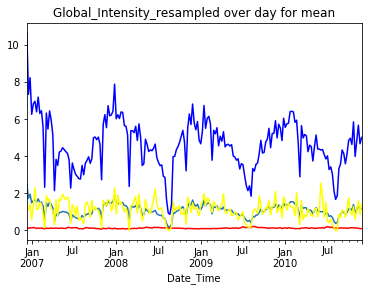

In [21]:
#######################################################
##### EDA - completed

##### 1.Graph of Active Power, Reactive Power, Sub-Metering over time

database.Global_active_power.resample('W').mean().plot(title='Global_active_power resampled over day for sum') 
database.Global_reactive_power.resample('W').mean().plot(title='Global_reactive_power resampled over day for mean', color='red') 
database.Sub_metering_1.resample('W').mean().plot(title='Sub_metering_1 resampled over day for mean', color='yellow') 
database.Global_intensity.resample('W').mean().plot(title='Global_Intensity_resampled over day for mean', color='blue') 

plt.show()   

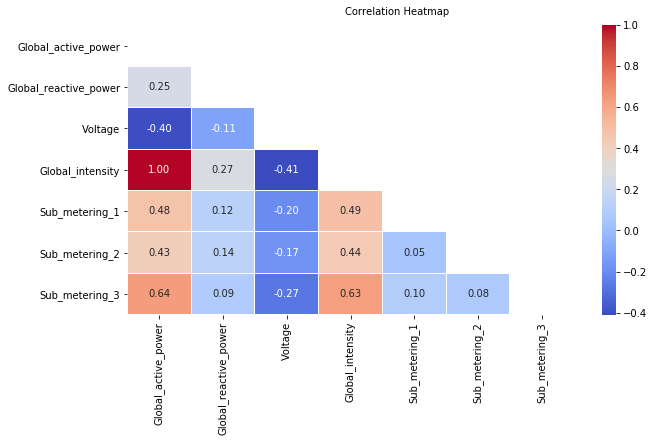

In [22]:
########################################################
###### Correlation Matrix - Completed

corr_database=database.corr()
corr_database=corr_database.round(2)
mask = np.triu(np.ones_like(corr_database, dtype=bool))

f, ax = plt.subplots(figsize=(10, 5))

hm = sns.heatmap(corr_database, annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05, cbar=True, mask=mask)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=10)
plt.show()


In [23]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out,1):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together

	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg 



In [24]:
####################################################################
############ Resampling

database_resample = database.resample('h').mean() 
values = database_resample.values 

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 2, 2)
#reframed.to_csv (r'C:\Users\Anson\OneDrive\Anson File\PythonApplication_anson\3_Kaggle\3_Household Electric Power Consumption_LSTM\reframed.csv', sep=';', index = False, header=True)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)


In [25]:
##################################################################
############################

# split into train and test sets

values = reframed.values
n_train_time = 365*24
train = values[:n_train_time , :]
test = values[n_train_time: , :]

# split into input and outputs

train_X, train_y = train[:, 0:7], train[:, 7]
test_X, test_y = test[:, 0:7], test[:, 7]


# reshape input to be 3D [samples, timesteps, features] for LSTM
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [26]:
###################################################################
############################ Model Formulation - Completed


Keras_model = Sequential()
Keras_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
Keras_model.add(Dropout(0.2))
Keras_model.add(Dense(1))
Keras_model.compile(optimizer='adam',loss='mean_squared_error')


## fit network
history = Keras_model.fit(train_X, train_y, epochs=20, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Train on 8760 samples, validate on 25381 samples
Epoch 1/20
8740/8760 [============================>.] - ETA: 0s - loss: 0.0151

C:\Users\Anson\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8760/8760 [==============================] - 4s 435us/sample - loss: 0.0151 - val_loss: 0.0101
Epoch 2/20
8760/8760 [==============================] - 3s 384us/sample - loss: 0.0110 - val_loss: 0.0093
Epoch 3/20
8760/8760 [==============================] - 3s 396us/sample - loss: 0.0107 - val_loss: 0.0093
Epoch 4/20
8760/8760 [==============================] - 4s 448us/sample - loss: 0.0106 - val_loss: 0.0092
Epoch 5/20
8760/8760 [==============================] - 4s 435us/sample - loss: 0.0105 - val_loss: 0.0092
Epoch 6/20
8760/8760 [==============================] - 5s 530us/sample - loss: 0.0105 - val_loss: 0.0092
Epoch 7/20
8760/8760 [==============================] - 4s 468us/sample - loss: 0.0105 - val_loss: 0.0092
Epoch 8/20
8760/8760 [==============================] - 4s 430us/sample - loss: 0.0105 - val_loss: 0.0091
Epoch 9/20
8760/8760 [==============================] - 4s 501us/sample - loss: 0.0105 - val_loss: 0.0092
Epoch 10/20
8760/8760 [==============================] - 

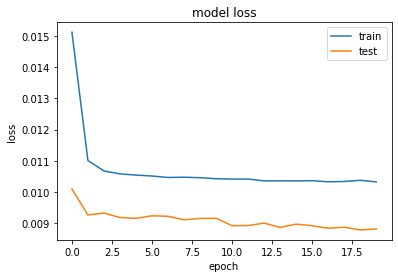

In [27]:
###################################################################
############################ Summarize the loss - Completed
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [28]:
###################################################################
############################ Prediction


y_predict = Keras_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


inv_y_predict = np.concatenate((y_predict, test_X[:, 1:7]), axis=1)
inv_y_predict = scaler.inverse_transform(inv_y_predict)
inv_y_predict = inv_y_predict[:,0]



test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:7]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

## calculate RMSE
rmse = mean_squared_error(inv_y, inv_y_predict,squared=False)

print('Test RMSE: %.3f' %rmse)

C:\Users\Anson\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Test RMSE: 0.604


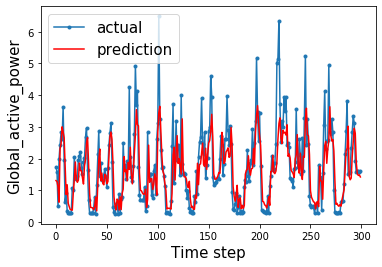

In [29]:
###################################################################
############################ Compairing The Predictions In 300 Hours

hour = 300
aa=[x for x in range(hour)]
plt.plot(aa, inv_y[:hour], marker='.', label="actual")
plt.plot(aa, inv_y_predict[:hour], 'r', label="prediction")
plt.xlabel('Time step', size=15)
plt.ylabel('Global_active_power', size=15)
plt.legend(fontsize=15)
plt.show()
